1) Naivni algoritam (5 bodova), test primer

2) Naivni algoritam,  DLT algoritam  i poredjenje za 4. korespodencije (8 bodova).

3) Naivni algoritam,  DLT algoritam, modifikovani DLT algoritam (sa normalizacijom). Testiranje šta se dešava pri promeni koordinata i poredjenje sa DLT algoritmom  za više od 4 korespodencije (12 bodova)

Dodatno: \\
4) (do 5 bodova) Napisati aplikaciju koja ucitava bmp sliku, korisnik bira  (mišem ili unosi koordinate) 4 piksela koji se slikaju u pravougaonik (odnos stranica može da unosi korisnik, a može i da ga odredi aplikacija), a aplikacija vraca sliku sa otklonjenom projektivnom distorzijom (poslednji slajd). 

ili

4') (do 8 bodova) Napisati funkciju koja učitava dve fotografije i od njih pravi panoramu. Korisnik identifikuje određen broj  (>= 4) tačaka  koje su "iste" na obe fotografije i na osnovu toga se računa projektivno preslikavanje koje "lepi" fotografije. Alternativno, može se koristiti SIFT biblioteka za odredjivanje tačaka. Implementacija RANSAC algoritma, ko želi.

***NAIVNI ALGORITAM***

In [170]:
import numpy as np
import matplotlib.pyplot as plt

In [183]:
# originalne tacke
src_points = [[-3, -1, 1],
              [3, -1, 1],
              [1, 1, 1],
              [-1, 1, 1]]

# slike tacaka
dst_points = [[-2, -1, 1],
              [2, -1, 1],
              [2, 1, 1],
              [-2, 1, 1]]

In [184]:
def find_matrix(pts):
    matrix = np.array([ # A, B, C
        [pts[0][0], pts[1][0], pts[2][0]],
        [pts[0][1], pts[1][1], pts[2][1]],
        [pts[0][2], pts[1][2], pts[2][2]]
    ])

    D = np.array([pts[3][0], pts[3][1], pts[3][2]])

    # D = alpha*A + beta*B + gamma*C
    result = np.linalg.solve(matrix, D)

    alpha = result[0]
    beta = result[1]
    gamma = result[2]

    column1= np.array([alpha*pts[0][0], alpha*pts[0][1], alpha*pts[0][2]])
    column2= np.array([beta*pts[1][0], beta*pts[1][1], beta*pts[1][2]])
    column3= np.array([gamma*pts[2][0], gamma*pts[2][1], gamma*pts[2][2]])

    P = np.column_stack([column1, column2, column3])

    return P

def naive_algorithm(src_p, dst_p):

    P1 = find_matrix(src_p)
    P2 = find_matrix(dst_p)

    # P = P2*inv(P1)
    P = np.dot(P2, np.linalg.inv(P1))

    return P

In [190]:
P_naive = naive_algorithm(src_points, dst_points)
P_naive = P_naive.round()
print(P_naive)

[[ 2. -0.  0.]
 [-0.  2. -1.]
 [ 0. -1.  2.]]


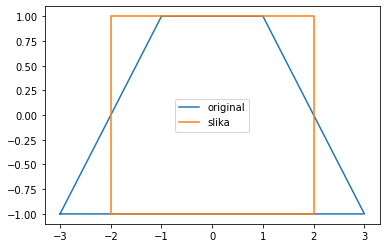

In [182]:
xs = [p[0] for p in src_points]
ys = [p[1] for p in src_points]
xs.append(src_points[0][0])
ys.append(src_points[0][1])

xd = [p[0] for p in dst_points]
yd = [p[1] for p in dst_points]
xd.append(dst_points[0][0])
yd.append(dst_points[0][1])

plt.plot(xs, ys)
plt.plot(xd, yd)
plt.legend(['original', 'slika'])
plt.show()

***DLT ALGORITAM***

In [221]:
def dlt(src_p, dst_p):
    x = src_p[0][0]
    y = src_p[0][1]
    z = src_p[0][2]

    u = dst_p[0][0]
    v = dst_p[0][1]
    w = dst_p[0][2]

    A = np.array([
        [0, 0, 0, -w*x, -w*y, -w*z, v*x, v*y, v*z],
        [w*x, w*y, w*z, 0, 0, 0, -u*x, -u*y, -u*z]
    ])

    for i in range(1, len(src_p)):
        x = src_p[i][0]
        y = src_p[i][1]
        z = src_p[i][2]

        u = dst_p[i][0]
        v = dst_p[i][1]
        w = dst_p[i][2]

        row1 = np.array([0, 0, 0, -w*x, -w*y, -w*z, v*x, v*y, v*z])
        row2 = np.array([w*x, w*y, w*z, 0, 0, 0, -u*x, -u*y, -u*z])

        A = np.vstack((A, row1))
        A = np.vstack((A, row2))

    # print(A.shape)
    # print(A)

    # SVD dekompozicija
    U, S, V = np.linalg.svd(A)

    P = V[-1].reshape(3,3)
    
    return P

In [223]:
P_dlt = dlt(src_points, dst_points)
print(P_dlt.round())

[[ 1.  0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]


***Poredjenje DLT i naivnog algoritma***

In [225]:
P_dlt = (P_dlt / P_dlt[0, 0]) * P_naive[0,0]
print(P_dlt.round())

[[ 2.  0. -0.]
 [-0.  2. -1.]
 [-0. -1.  2.]]


In [227]:
P_dlt.round() == P_naive.round()

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

***MODIFIKOVANI DLT ALGORITAM***